# With equal performance, does increased reliance on C increase model robustness?

In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn.metrics import average_precision_score
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform, shortcut_noise_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

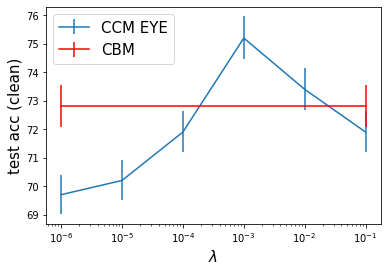

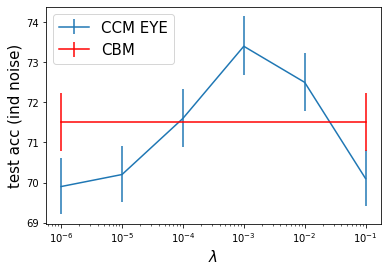

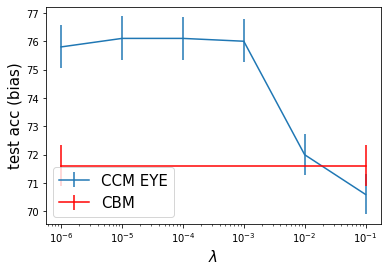

In [44]:
# key is dim_noise, value is [clean acc, t=0, t=1]
perf_dict_eye = {
    1e-6: [69.7, 69.9, 75.8], # actually is 0
    1e-5: [70.2, 70.2, 76.1],
    1e-4: [71.9, 71.6, 76.1], 
    1e-3: [75.2, 73.4, 76],
    1e-2: [73.4, 72.5, 72.0],
    1e-1: [71.9, 70.1, 70.6]
}

perf_dict_wl2 = { # EYE
    1e-6: [70.2, 70.7, 76.0], 
    1e-5: [71.9, 71.6, 76.5],
    1e-4: [74.7, 73.0, 76.1], 
    1e-3: [75.3, 73.7, 75.6],
    1e-2: [74.2, 73.0, 73.4],
    1e-1: [73.4, 72.0, 72.2]
}

perf_dict_cbm = { # lambda independent
    1e-6: [72.8, 71.5, 71.6],    
    1e-1: [72.8, 71.5, 71.6],     
}

def get_error(p, n=100):
    '''bootstrap'''
    assert 0 <= p <= 1, "probablity is non-negative"
    n_test = 5790 # number of test data in cub
    a, b = np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [2.5, 97.5])
    return a, b

def plot_d_noise(d, dim=0, label=None, color=None):
    x = d.keys()
    y = list(map(lambda x: x[dim], d.values()))
    yerr = list(zip(*[get_error(a/100.0) for a in y]))
    plt.gca().set_xscale("log", nonpositive='clip')
    plt.errorbar(x, y, yerr=yerr, label=label, color=color)
    
xlabel = r"$\lambda$"

plot_d_noise(perf_dict_eye, 0, "CCM EYE")
# plot_d_noise(perf_dict_wl2, 0, "CCM wl2")
plot_d_noise(perf_dict_cbm, 0, "CBM", color='red')
plt.ylabel('test acc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/clean_lambda_cub.png')
plt.show()

plot_d_noise(perf_dict_eye, 1, "CCM EYE")
# plot_d_noise(perf_dict_wl2, 1, "CCM wl2")
plot_d_noise(perf_dict_cbm, 1, "CBM", color='red')
plt.ylabel('test acc (ind noise)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/ind_lambda_cub.png')
plt.show()

plot_d_noise(perf_dict_eye, 2, "CCM EYE")
# plot_d_noise(perf_dict_wl2, 2, "CCM wl2")
plot_d_noise(perf_dict_cbm, 2, "CBM", color='red')
plt.ylabel('test acc (bias)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/bias_lambda_cub.png')
plt.show()

# some deprecated stuff

In [27]:
def attribution_ratio(attribution, concept_indices):
    '''
    attribution assumed to be (n_classes, n_concepts)
    concept_indices: indices of concepts
    '''
    ratio = attribution[:, concept_indices].abs().sum() / attribution.abs().sum()
    return ratio.item()

# net = torch.load('../outputs/dnoise0/98baaeec126b11ecb773ac1f6b24a434/ccm.pt') # lambda = 0.1
# net = torch.load('../outputs/dnoise0/36740f0aea7311ebb773ac1f6b24a434/ccm.pt') # lambda = 0
net = torch.load('../outputs/4aac12a4128911ecb773ac1f6b24a434/ccm.pt') # wl2 lambda = 0.1

n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.9756828546524048
average precision 1.0000000000000002


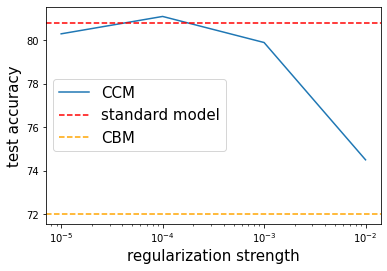

In [20]:
alphas = [1e-2, 1e-3, 1e-4, 1e-5]
accs = [74.5, 79.9, 81.1, 80.3] # [74.4, 80.1, 80.8, 81.1]
concept_ratios = [0.986, 0.883, 0.516, 0.346]
AP = [1, 1, 1, 0.409]

# 0:      81.2 0.331 0.332, 80.8, (tid: 25f46764dd0e11ebb773ac1f6b24a434)
# 1e-5: 81.1 0.346 0.409, 80.3
# 1e-4: 80.8 0.516 1.00, 81.1
# 1e-3: 80.1 0.883 1.00, 79.9
# 1e-2: 74.4 0.986 1.00, 74.5

plt.semilogx(alphas, accs, label='CCM')
plt.axhline(80.8, ls='--', color='red', label='standard model')
plt.axhline(72.0, ls='--', color='orange', label='CBM')
plt.legend(fontsize=15)
plt.xlabel('regularization strength', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.show()

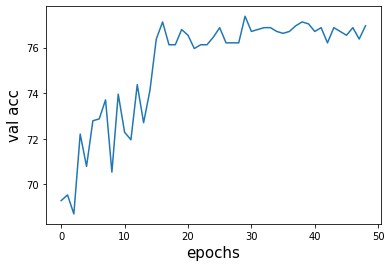

In [23]:
plot_log(torch.load("../outputs/dnoise0/d749eff0ea5311ebb773ac1f6b24a434/ccm.log"), key='val acc')